# 🔋 Battery Quality Analysis & Defect Detection
**Dataset:** NASA PCoE Li-ion Battery Dataset (B0005, B0006, B0007, B0018)

This notebook analyzes battery degradation, performs EDA, builds defect classification and RUL regression models, and saves artifacts for deployment.

## 1. Setup & Data Loading
- Import libraries
- Define robust loader for `.mat` files
- Load `B0005.mat`, `B0006.mat`, `B0007.mat`, `B0018.mat` (assumed to be in the same folder)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

def _to_1d(x):
    if x is None:
        return None
    a = np.array(x).squeeze()
    return a

def load_battery_mat(mat_path: str, battery_name: str):
    """
    Load one NASA battery MAT file (B0005/B0006/B0007/B0018).
    Uses the loop index as the discharge cycle number (since some files don't store it explicitly).
    Returns:
        df_cycles: one row per discharge cycle (capacity + engineered features)
        df_ts: time-series (t, voltage, current, temperature) for each discharge cycle
        df_imp: impedance measurements if present (may be empty)
    """
    mat = loadmat(mat_path, squeeze_me=True, struct_as_record=False)
    B = mat[battery_name]
    cycles = np.atleast_1d(B.cycle)

    rows_cycles, ts_frames, imp_rows = [], [], []
    discharge_idx, impedance_idx = 0, 0

    for cyc in cycles:
        ctype = str(cyc.type).lower().strip()
        if 'discharge' in ctype:
            discharge_idx += 1
            d = cyc.data
            cap = float(np.array(d.Capacity).squeeze())
            t   = _to_1d(getattr(d, 'Time', None))
            vu  = _to_1d(getattr(d, 'Voltage_measured', None))
            cu  = _to_1d(getattr(d, 'Current_measured', None))
            tm  = _to_1d(getattr(d, 'Temperature_measured', None))
            ambient = getattr(cyc, 'ambient_temperature', None)
            ambient = float(np.array(ambient).squeeze()) if ambient is not None else np.nan
            duration     = float(t[-1]) if t is not None and len(t) else np.nan
            min_voltage  = float(np.nanmin(vu)) if vu is not None and len(vu) else np.nan
            mean_current = float(np.nanmean(cu)) if cu is not None and len(cu) else np.nan
            mean_temp    = float(np.nanmean(tm)) if tm is not None and len(tm) else np.nan
            rows_cycles.append({
                'battery': battery_name,
                'cycle': discharge_idx,
                'capacity': cap,
                'ambient_temp': ambient,
                'duration': duration,
                'min_voltage': min_voltage,
                'mean_current': mean_current,
                'mean_temp': mean_temp,
            })
            if t is not None:
                ts = pd.DataFrame({'t': t})
                if vu is not None: ts['voltage'] = vu
                if cu is not None: ts['current'] = cu
                if tm is not None: ts['temperature'] = tm
                ts['battery'] = battery_name
                ts['cycle'] = discharge_idx
                ts_frames.append(ts)
        elif 'impedance' in ctype:
            impedance_idx += 1
            idata = cyc.data
            IR = getattr(idata, 'IR', None)
            R  = getattr(idata, 'R', None)
            Z  = getattr(idata, 'Z', None)
            val = np.nan
            if IR is not None:
                arr = _to_1d(IR); val = float(np.nanmean(arr))
            elif R is not None:
                arr = _to_1d(R); val = float(np.nanmean(arr))
            elif Z is not None:
                arr = _to_1d(Z)
                arr = np.abs(arr.astype(np.complex128)) if np.iscomplexobj(arr) else arr
                val = float(np.nanmean(arr))
            imp_rows.append({'battery': battery_name, 'imp_cycle': impedance_idx, 'impedance': val})

    df_cycles = pd.DataFrame(rows_cycles).sort_values(['battery', 'cycle']).reset_index(drop=True)
    df_ts = pd.concat(ts_frames, ignore_index=True) if ts_frames else pd.DataFrame()
    df_imp = pd.DataFrame(imp_rows).sort_values(['battery', 'imp_cycle']).reset_index(drop=True)
    if not df_cycles.empty:
        df_cycles['fade_rate'] = df_cycles.groupby('battery')['capacity'].diff()
    return df_cycles, df_ts, df_imp

# Load all four batteries (assumes .mat files are in the same directory)
batteries = ['B0005', 'B0006', 'B0007', 'B0018']
cycles_list, ts_list, imp_list = [], [], []
for b in batteries:
    c, ts, imp = load_battery_mat(f"{b}.mat", b)
    cycles_list.append(c)
    if not ts.empty:  ts_list.append(ts)
    if not imp.empty: imp_list.append(imp)

df = pd.concat(cycles_list, ignore_index=True).sort_values(['battery','cycle']).reset_index(drop=True)
df_ts = pd.concat(ts_list, ignore_index=True) if ts_list else pd.DataFrame()
df_imp = pd.concat(imp_list, ignore_index=True) if imp_list else pd.DataFrame()

df.head()

,battery,cycle,capacity,ambient_temp,duration,min_voltage,mean_current,mean_temp,fade_rate
0,B0005,1,1.856487,24.0,3690.234,2.612467,-1.818702,32.572328,NaN
1,B0005,2,1.846327,24.0,3672.344,2.587209,-1.817560,32.725235,-0.010160
2,B0005,3,1.835349,24.0,3651.641,2.651917,-1.816487,32.642862,-0.010978
3,B0005,4,1.835263,24.0,3631.563,2.592948,-1.825589,32.514876,-0.000087
4,B0005,5,1.834646,24.0,3629.172,2.547420,-1.826114,32.382349,-0.000617


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636 entries, 0 to 635
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   battery       636 non-null    object 
 1   cycle         636 non-null    int64  
 2   capacity      636 non-null    float64
 3   ambient_temp  636 non-null    float64
 4   duration      636 non-null    float64
 5   min_voltage   636 non-null    float64
 6   mean_current  636 non-null    float64
 7   mean_temp     636 non-null    float64
 8   fade_rate     632 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 44.8+ KB


In [3]:
df.describe(include='all')

,battery,cycle,capacity,ambient_temp,duration,min_voltage,mean_current,mean_temp,fade_rate
count,636,636.000000,636.000000,636.0,636.000000,636.000000,636.000000,636.000000,632.000000
unique,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,B0005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,80.764151,1.581652,24.0,3116.977701,2.387737,-1.834069,32.327555,-0.003724
std,NaN,47.137103,0.198765,0.0,242.197224,0.219906,0.102726,0.971147,0.018082
min,NaN,1.000000,1.153818,24.0,2742.843000,1.737030,-1.999755,30.102704,-0.062827
25%,NaN,40.000000,1.421123,24.0,2891.996250,2.186663,-1.912601,31.516568,-0.010505
50%,NaN,80.000000,1.559695,24.0,3084.281000,2.421034,-1.851050,32.368347,-0.005376
75%,NaN,120.000000,1.763486,24.0,3311.828000,2.529182,-1.773023,33.175118,-0.000432


## 2. Initial Data Exploration
- Structure & completeness
- Missing values & quick sanity checks

In [4]:
print('Columns:', df.columns.tolist())
print('Rows:', len(df), '| Batteries:', df['battery'].nunique())
print('Cycles per battery:\n', df.groupby('battery')['cycle'].max())
print('\nMissing values per column:\n', df.isna().sum())

for col in ['capacity','duration','min_voltage','mean_current','mean_temp','fade_rate']:
    if col in df.columns:
        q = df[col].quantile([0.01, 0.99])
        print(f"{col:>12} 1%={q.iloc[0]:.4f}, 99%={q.iloc[1]:.4f}, min={df[col].min():.4f}, max={df[col].max():.4f}")

Columns: ['battery', 'cycle', 'capacity', 'ambient_temp', 'duration', 'min_voltage', 'mean_current', 'mean_temp', 'fade_rate']
Rows: 636 | Batteries: 4
Cycles per battery:
 battery
B0005    168
B0006    168
B0007    168
B0018    132
Name: cycle, dtype: int64

Missing values per column:
 battery         0
cycle           0
capacity        0
ambient_temp    0
duration        0
min_voltage     0
mean_current    0
mean_temp       0
fade_rate       4
dtype: int64
    capacity 1%=1.1854, 99%=1.9932, min=1.1538, max=2.0353
    duration 1%=2776.8996, 99%=3652.2810, min=2742.8430, max=3690.2340
 min_voltage 1%=1.8501, 99%=2.6981, min=1.7370, max=2.7000
mean_current 1%=-1.9896, 99%=-1.5477, min=-1.9998, max=-1.5170
   mean_temp 1%=30.3895, 99%=34.1713, min=30.1027, max=34.4905
   fade_rate 1%=-0.0329, 99%=0.0859, min=-0.0628, max=0.1519


## 3. Visual Explorations
### 3.1 Capacity fade curves

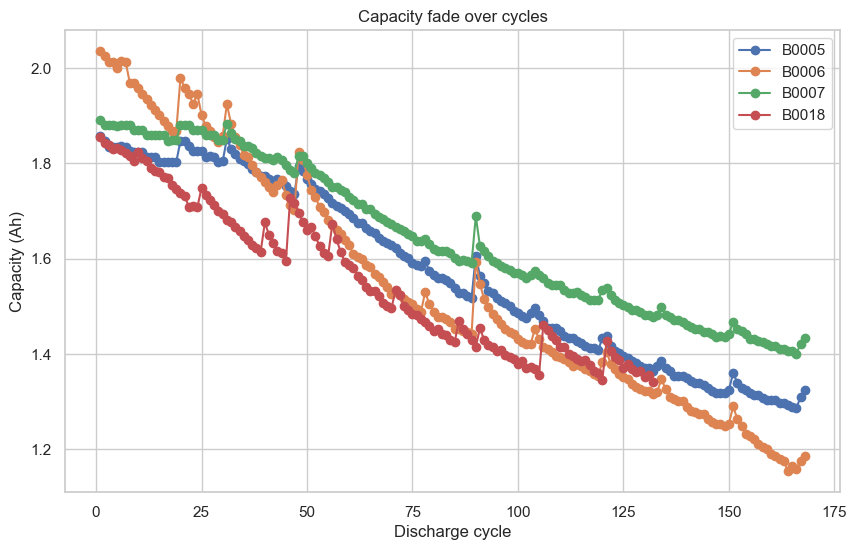

In [5]:
plt.figure()
for b in df['battery'].unique():
    s = df[df['battery']==b]
    plt.plot(s['cycle'], s['capacity'], marker='o', label=b)
plt.xlabel('Discharge cycle'); plt.ylabel('Capacity (Ah)')
plt.title('Capacity fade over cycles'); plt.legend(); plt.show()

### 3.2 Time-series snapshot (voltage / temperature / current)

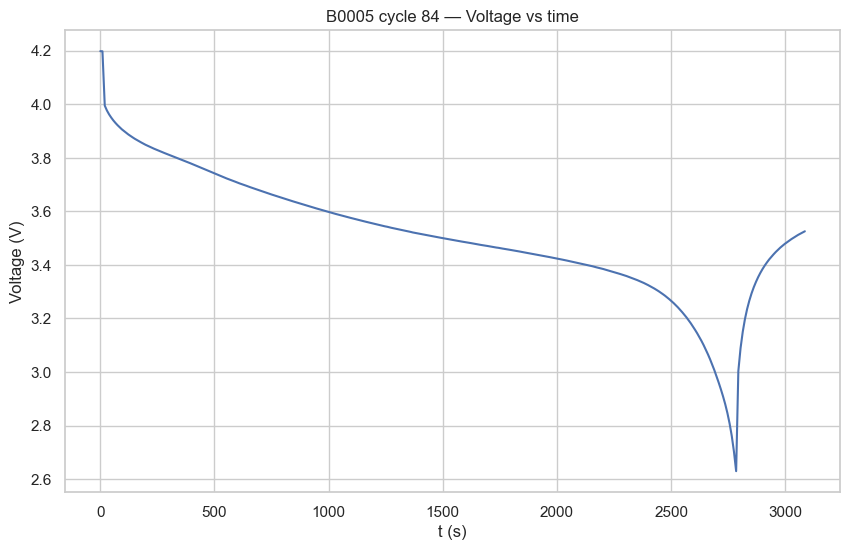

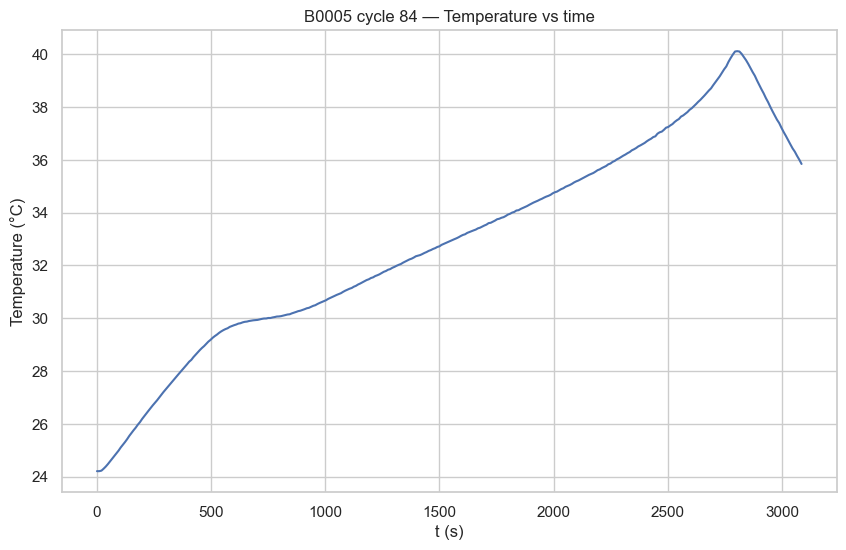

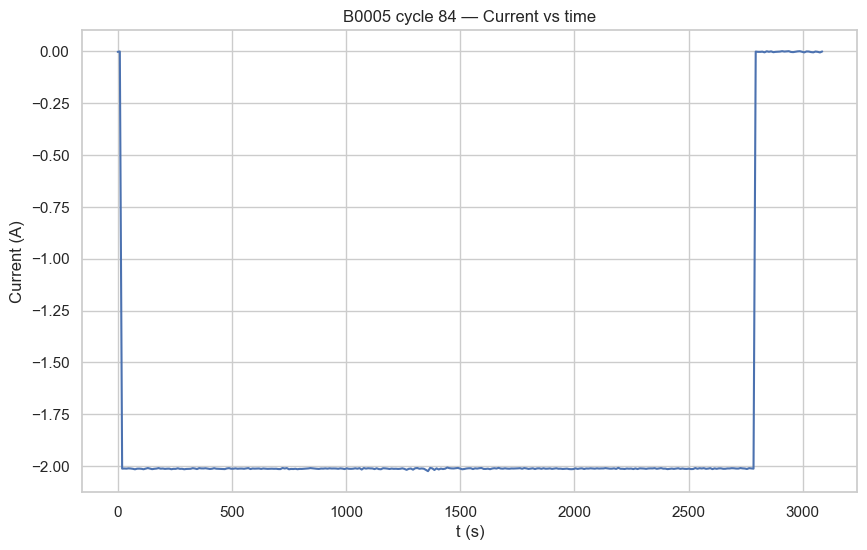

In [6]:
if not df_ts.empty:
    sample_batt = df['battery'].iloc[0]
    sample_cycle = int(df[df['battery']==sample_batt]['cycle'].median())
    s = df_ts[(df_ts['battery']==sample_batt) & (df_ts['cycle']==sample_cycle)].copy()
    if not s.empty and 'voltage' in s:
        plt.figure(); plt.plot(s['t'], s['voltage']);
        plt.xlabel('t (s)'); plt.ylabel('Voltage (V)');
        plt.title(f'{sample_batt} cycle {sample_cycle} — Voltage vs time'); plt.show()
    if not s.empty and 'temperature' in s:
        plt.figure(); plt.plot(s['t'], s['temperature']);
        plt.xlabel('t (s)'); plt.ylabel('Temperature (°C)');
        plt.title(f'{sample_batt} cycle {sample_cycle} — Temperature vs time'); plt.show()
    if not s.empty and 'current' in s:
        plt.figure(); plt.plot(s['t'], s['current']);
        plt.xlabel('t (s)'); plt.ylabel('Current (A)');
        plt.title(f'{sample_batt} cycle {sample_cycle} — Current vs time'); plt.show()

## 4. KPI & Derived Metric Analysis
- Failure threshold (70% of initial capacity)
- Cycles to failure per battery
- Pairwise relationships

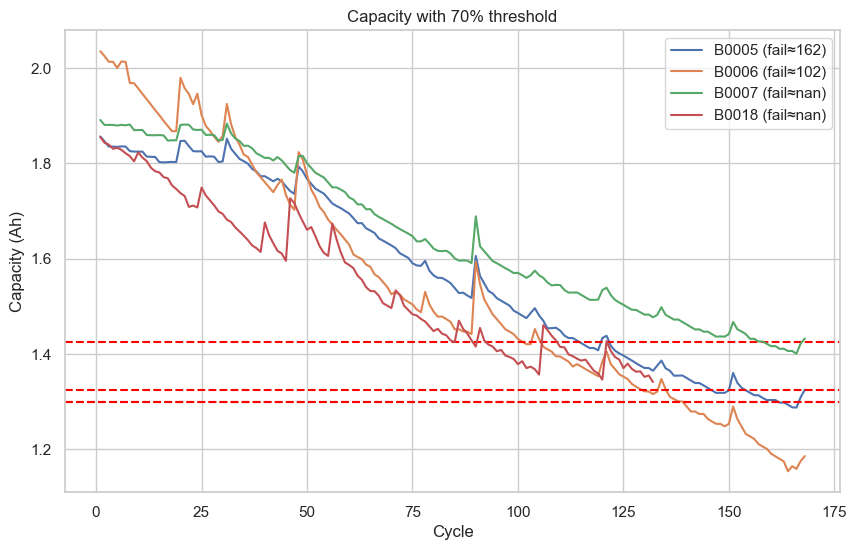

,battery,initial_capacity,threshold,failure_cycle
0,B0005,1.856487,1.299541,162.0
1,B0006,2.035338,1.424736,102.0
2,B0007,1.891052,1.323737,NaN
3,B0018,1.855005,1.298503,NaN


In [8]:
kpi = []
plt.figure()
for b in df['battery'].unique():
    s = df[df['battery']==b].copy()
    init_cap = s['capacity'].iloc[0]
    thr = 0.7 * init_cap
    fail_cycle = s.loc[s['capacity'] < thr, 'cycle'].min()
    kpi.append({'battery': b, 'initial_capacity': init_cap, 'threshold': thr, 'failure_cycle': fail_cycle})
    plt.plot(s['cycle'], s['capacity'], label=f"{b} (fail≈{fail_cycle})")
    plt.axhline(thr, linestyle='--', color='red')
plt.xlabel('Cycle'); plt.ylabel('Capacity (Ah)'); plt.title('Capacity with 70% threshold'); plt.legend(); plt.show()
kpi_df = pd.DataFrame(kpi); kpi_df

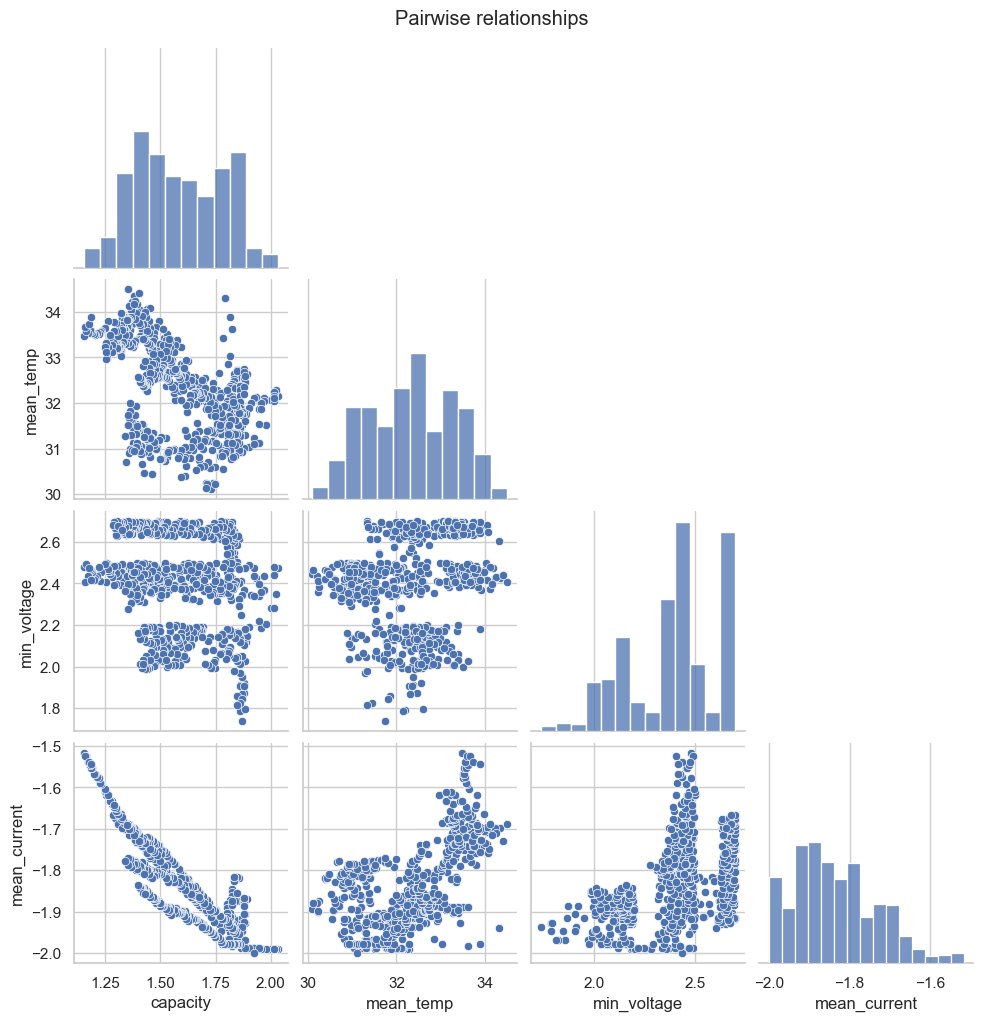

In [9]:
sns.pairplot(df[[c for c in ['capacity','mean_temp','min_voltage','mean_current'] if c in df.columns]].dropna(), corner=True)
plt.suptitle('Pairwise relationships', y=1.02); plt.show()

## 5. Correlation Analysis

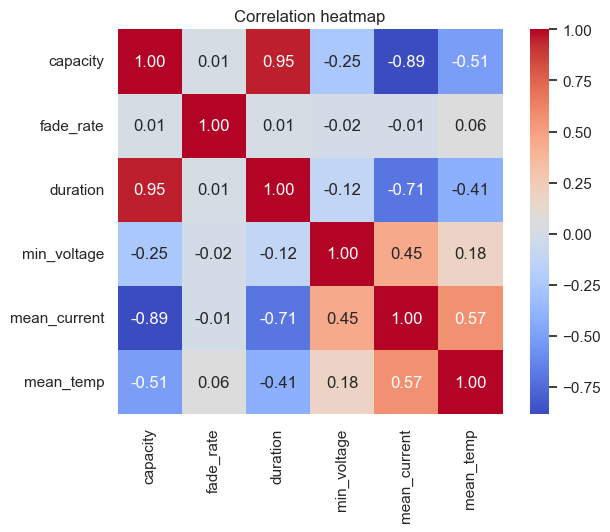

In [11]:
corr_cols = [c for c in ['capacity','fade_rate','duration','min_voltage','mean_current','mean_temp'] if c in df.columns]
corr = df[corr_cols].dropna().corr()
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation heatmap'); plt.show()

## 6. Defect Labeling & Anomaly Detection Prep
- Label defective cycles (capacity < 70% of initial)
- Quick anomaly flag via fade-rate z-score

Defective cycles per battery:
 battery
B0005     5
B0006    65
B0007     0
B0018     0
Name: defect, dtype: int64


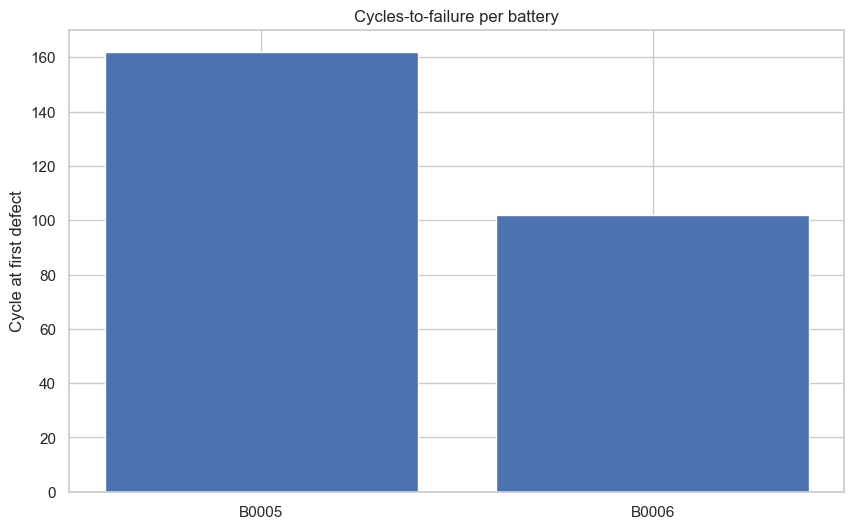

Anomalies flagged (fade_rate z < -3): 1


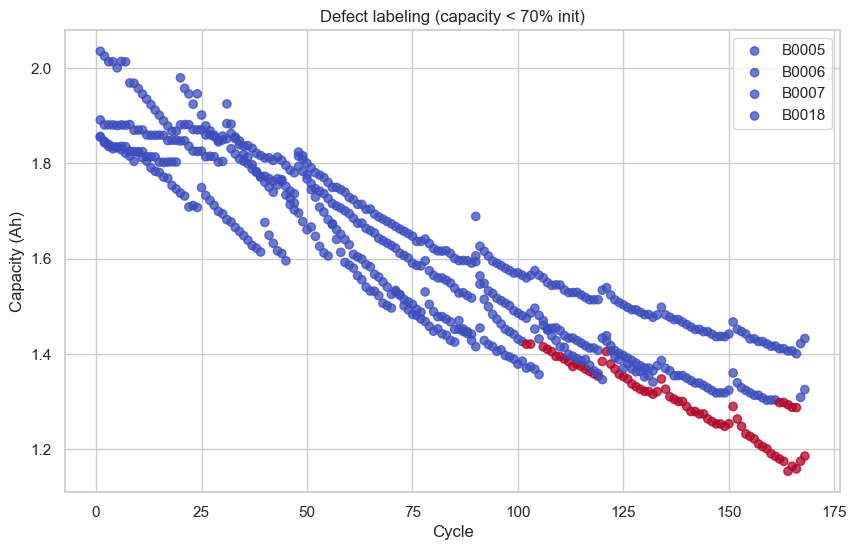

In [12]:
df['init_cap'] = df.groupby('battery')['capacity'].transform('first')
df['threshold'] = 0.7 * df['init_cap']
df['defect'] = df['capacity'] < df['threshold']
print('Defective cycles per battery:\n', df.groupby('battery')['defect'].sum())

fail_at = df[df['defect']].groupby('battery')['cycle'].min().dropna()
if not fail_at.empty:
    plt.figure(); plt.bar(fail_at.index, fail_at.values)
    plt.ylabel('Cycle at first defect'); plt.title('Cycles-to-failure per battery'); plt.show()

if 'fade_rate' in df.columns:
    fr = df['fade_rate']
    z = (fr - fr.mean()) / fr.std(ddof=0)
    df['fade_rate_z'] = z
    df['anomaly'] = (z < -3)
    print('Anomalies flagged (fade_rate z < -3):', df['anomaly'].sum())

plt.figure()
for b in df['battery'].unique():
    s = df[df['battery']==b]
    plt.scatter(s['cycle'], s['capacity'], c=s['defect'].astype(int), cmap='coolwarm', alpha=0.75, label=b)
plt.xlabel('Cycle'); plt.ylabel('Capacity (Ah)'); plt.title('Defect labeling (capacity < 70% init)'); plt.legend(); plt.show()

## 7. Insights & Summary (EDA)
See expanded Section in README/notebook for narrative.

## 8. Summary of Findings
*Expanded narrative provided in the README; keep concise bullets here for the notebook.*
- Non-linear capacity fade; faster near end-of-life
- Different cycles-to-failure per cell
- Fade-rate, min-voltage, mean-temp are informative
- Clear defect label at 70% threshold

## 9. Modeling — Defect Classification

In [13]:
from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

feature_cols = [c for c in ['fade_rate','duration','min_voltage','mean_current','mean_temp','ambient_temp'] if c in df.columns]
X = df[feature_cols].copy()
y = df['defect'].astype(int).copy()
groups = df['battery'].values
gkf = GroupKFold(n_splits=min(4, df['battery'].nunique()))

logreg_clf = Pipeline(steps=[
    ('imp', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced'))
])

accs, f1s, rocs = [], [], []
for fold, (tr, te) in enumerate(gkf.split(X, y, groups=groups), start=1):
    logreg_clf.fit(X.iloc[tr], y.iloc[tr])
    p = logreg_clf.predict(X.iloc[te])
    proba = logreg_clf.predict_proba(X.iloc[te])[:,1]
    acc = accuracy_score(y.iloc[te], p)
    _, _, f1, _ = precision_recall_fscore_support(y.iloc[te], p, average='binary', zero_division=0)
    try:
        roc = roc_auc_score(y.iloc[te], proba)
    except ValueError:
        roc = float('nan')
    accs.append(acc); f1s.append(f1); rocs.append(roc)
    print(f'Fold {fold}: ACC={acc:.3f}  F1={f1:.3f}  ROC-AUC={roc:.3f}')

print("\nLogReg CV — ACC: %.3f±%.3f | F1: %.3f±%.3f | ROC-AUC: %.3f±%.3f" %
      (np.nanmean(accs), np.nanstd(accs), np.nanmean(f1s), np.nanstd(f1s), np.nanmean(rocs), np.nanstd(rocs)))

Fold 1: ACC=0.768  F1=0.000  ROC-AUC=nan
Fold 2: ACC=0.929  F1=0.915  ROC-AUC=0.998
Fold 3: ACC=0.643  F1=0.143  ROC-AUC=0.979
Fold 4: ACC=1.000  F1=0.000  ROC-AUC=nan

LogReg CV — ACC: 0.835±0.139 | F1: 0.265±0.380 | ROC-AUC: 0.988±0.009


In [14]:
from sklearn.ensemble import RandomForestClassifier
accs, f1s, rocs = [], [], []
rf = RandomForestClassifier(n_estimators=400, max_depth=None, min_samples_split=4,
                           class_weight='balanced_subsample', random_state=42)
imp = SimpleImputer(strategy='median')
for fold, (tr, te) in enumerate(gkf.split(X, y, groups=groups), start=1):
    Xtr = imp.fit_transform(X.iloc[tr]); Xte = imp.transform(X.iloc[te])
    rf.fit(Xtr, y.iloc[tr])
    p = rf.predict(Xte)
    proba = rf.predict_proba(Xte)[:,1]
    acc = accuracy_score(y.iloc[te], p)
    _, _, f1, _ = precision_recall_fscore_support(y.iloc[te], p, average='binary', zero_division=0)
    try:
        roc = roc_auc_score(y.iloc[te], proba)
    except ValueError:
        roc = float('nan')
    accs.append(acc); f1s.append(f1); rocs.append(roc)
    print(f'Fold {fold}: ACC={acc:.3f}  F1={f1:.3f}  ROC-AUC={roc:.3f}')

print("\nRandomForest CV — ACC: %.3f±%.3f | F1: %.3f±%.3f | ROC-AUC: %.3f±%.3f" %
      (np.nanmean(accs), np.nanstd(accs), np.nanmean(f1s), np.nanstd(f1s), np.nanmean(rocs), np.nanstd(rocs)))

Fold 1: ACC=1.000  F1=0.000  ROC-AUC=nan
Fold 2: ACC=0.649  F1=0.169  ROC-AUC=0.830
Fold 3: ACC=0.774  F1=0.208  ROC-AUC=0.925
Fold 4: ACC=1.000  F1=0.000  ROC-AUC=nan

RandomForest CV — ACC: 0.856±0.151 | F1: 0.094±0.095 | ROC-AUC: 0.878±0.048


## 10. Modeling — RUL (Remaining Useful Life) Regression

In [15]:
# 10.1 Target Engineering: RUL per cycle
rul_df = df.copy()
fail_map = (rul_df[rul_df['defect']].groupby('battery')['cycle'].min().rename('first_fail_cycle'))
rul_df = rul_df.merge(fail_map, on='battery', how='left')
rul_df['RUL'] = rul_df['first_fail_cycle'] - rul_df['cycle']
rul_df = rul_df.dropna(subset=['RUL']).reset_index(drop=True)

feature_cols = [c for c in ['fade_rate','duration','min_voltage','mean_current','mean_temp','ambient_temp'] if c in rul_df.columns]
from sklearn.impute import SimpleImputer
imp_rul = SimpleImputer(strategy='median')
Xr_imp = imp_rul.fit_transform(rul_df[feature_cols])
yr = rul_df['RUL'].astype(float)
groups_rul = rul_df['battery'].reset_index(drop=True)

In [16]:
# 10.2 CV with dynamic splits
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupKFold, KFold

def cv_regressor_grouped(model, X, y, groups, max_splits=4, random_state=42):
    groups = pd.Series(groups).reset_index(drop=True)
    y = pd.Series(y).reset_index(drop=True)
    n_groups = groups.nunique()
    if n_groups >= 2:
        n_splits = min(max_splits, n_groups)
        splitter = GroupKFold(n_splits=n_splits)
        split_iter = splitter.split(X, y, groups=groups)
    else:
        n_splits = min(max_splits, len(y))
        splitter = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        split_iter = splitter.split(X, y)
    maes, rmses = [], []
    for fold, (tr, te) in enumerate(split_iter, start=1):
        model.fit(X[tr], y.iloc[tr])
        p = model.predict(X[te])
        mae = mean_absolute_error(y.iloc[te], p)
        rmse = np.sqrt(mean_squared_error(y.iloc[te], p))
        maes.append(mae); rmses.append(rmse)
        print(f'Fold {fold}: MAE={mae:.2f}  RMSE={rmse:.2f}')
    print('CV — MAE: %.2f±%.2f | RMSE: %.2f±%.2f' % (np.mean(maes), np.std(maes), np.mean(rmses), np.std(rmses)))
    return maes, rmses

print('Linear Regression (baseline)')
_ = cv_regressor_grouped(LinearRegression(), Xr_imp, yr, groups_rul)

print('\nGradient Boosting Regressor')
gbr = GradientBoostingRegressor(random_state=42)
_ = cv_regressor_grouped(gbr, Xr_imp, yr, groups_rul)

Linear Regression (baseline)
Fold 1: MAE=59.80  RMSE=61.19
Fold 2: MAE=55.55  RMSE=56.61
CV — MAE: 57.67±2.13 | RMSE: 58.90±2.29

Gradient Boosting Regressor
Fold 1: MAE=53.88  RMSE=54.41
Fold 2: MAE=56.23  RMSE=57.05
CV — MAE: 55.05±1.17 | RMSE: 55.73±1.32


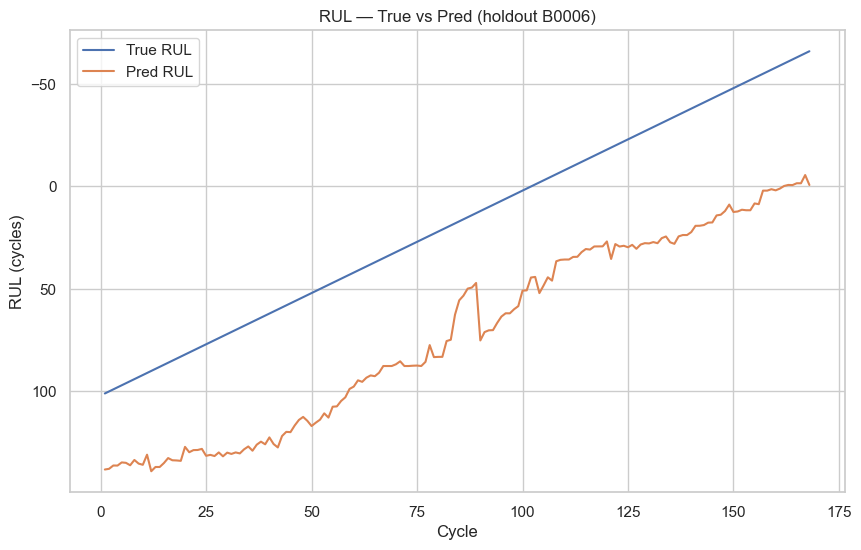

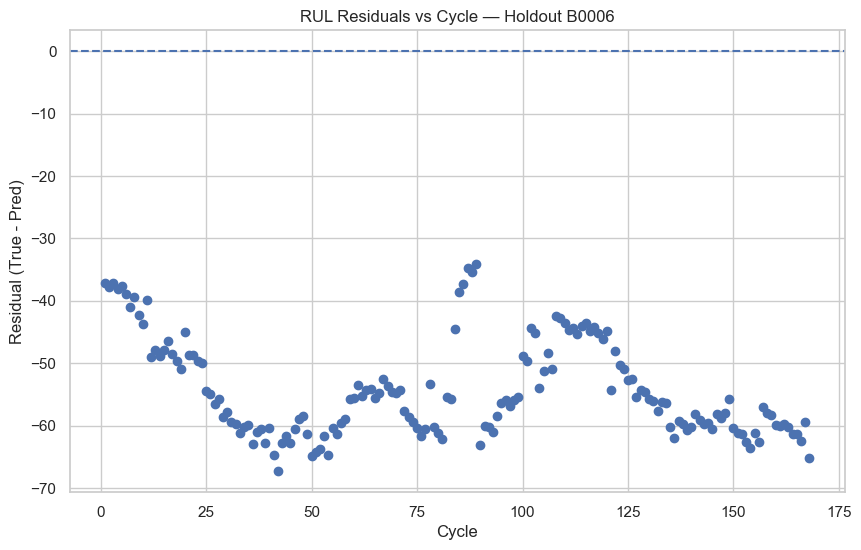

In [17]:
# 10.3 Hold-out battery plots (robust)
rul_batts = rul_df['battery'].unique().tolist()
holdout_batt = rul_batts[-1] if len(rul_batts)>0 else None
if holdout_batt is not None:
    mask_te = (rul_df['battery'] == holdout_batt).values
    mask_tr = ~mask_te
    if mask_te.sum() >= 10 and mask_tr.sum() >= 10:
        gbr_hold = GradientBoostingRegressor(random_state=123)
        gbr_hold.fit(Xr_imp[mask_tr], yr.iloc[mask_tr])
        pred_rul = gbr_hold.predict(Xr_imp[mask_te])
        plt.figure();
        plt.plot(rul_df.loc[mask_te, 'cycle'], yr.iloc[mask_te], label='True RUL')
        plt.plot(rul_df.loc[mask_te, 'cycle'], pred_rul, label='Pred RUL')
        plt.gca().invert_yaxis(); plt.xlabel('Cycle'); plt.ylabel('RUL (cycles)');
        plt.title(f'RUL — True vs Pred (holdout {holdout_batt})'); plt.legend(); plt.show()
        resid = yr.iloc[mask_te] - pred_rul
        plt.figure(); plt.scatter(rul_df.loc[mask_te, 'cycle'], resid)
        plt.axhline(0, linestyle='--'); plt.xlabel('Cycle'); plt.ylabel('Residual (True - Pred)')
        plt.title(f'RUL Residuals vs Cycle — Holdout {holdout_batt}')
        plt.show()
    else:
        print(f'Skipping holdout plot for {holdout_batt}: not enough rows.')
else:
    print('No batteries with known failure for RUL plotting.')

## 11. Save Artifacts for Deployment (Streamlit)

In [18]:
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

# Refit classifier on all data (with imputation)
imp_cls = SimpleImputer(strategy='median')
X_cls_imp_all = imp_cls.fit_transform(df[feature_cols])
y_cls_all = df['defect'].astype(int).values
rf_all = RandomForestClassifier(n_estimators=500, max_depth=None, min_samples_split=4,
                               class_weight='balanced_subsample', random_state=7)
rf_all.fit(X_cls_imp_all, y_cls_all)

# Refit regressor on all RUL rows (with imputation)
imp_r_all = SimpleImputer(strategy='median')
X_r_all = imp_r_all.fit_transform(rul_df[feature_cols]) if len(rul_df)>0 else None
y_r_all = rul_df['RUL'].astype(float).values if len(rul_df)>0 else None
if X_r_all is not None:
    from sklearn.ensemble import GradientBoostingRegressor
    gbr_all = GradientBoostingRegressor(random_state=7)
    gbr_all.fit(X_r_all, y_r_all)
    joblib.dump({'imputer': imp_r_all, 'model': gbr_all, 'features': feature_cols}, 'rul_gbr.joblib')

joblib.dump({'imputer': imp_cls, 'model': rf_all, 'features': feature_cols}, 'clf_rf.joblib')
print('Saved: clf_rf.joblib', 'and', 'rul_gbr.joblib' if X_r_all is not None else '(RUL model skipped)')

Saved: clf_rf.joblib and rul_gbr.joblib
